# Homework 3

This assignment covers Harris corner detector, RANSAC and HOG descriptor.

这份作业涵盖的知识点有：
- Harris 角点检测器
- RANSAC 随机抽样一致
- HOG 描述子

In [3]:
#coding:utf-8
# Setup
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import matplotlib.pyplot as plt
from time import time

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#有中文出现的情况，需要u'内容'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction: Panorama Stitching ：全景拼接
Panorama stitching is an early success of computer vision. Matthew Brown and David G. Lowe published a famous [panoramic image stitching paper](http://matthewalunbrown.com/papers/ijcv2007.pdf) in 2007. Since then, automatic panorama stitching technology has been widely adopted in many applications such as Google Street View, panorama photos on smartphones,
and stitching software such as Photosynth and AutoStitch.

In this assignment, we will detect and match keypoints from multiple images to build a single panoramic image. This will involve several tasks:
1. Use Harris corner detector to find keypoints.
2. Build a descriptor to describe each point in an image. <br>
   Compare two sets of descriptors coming from two different images and find matching keypoints.
3. Given a list of matching keypoints, use least-squares method to find the affine transformation matrix that maps points in one image to another.
4. Use RANSAC to give a more robust estimate of affine transformation matrix. <br>
   Given the transformation matrix, use it to transform the second image and overlay it on the first image, forming a panorama.
5. Implement a different descriptor (HOG descriptor) and get another stitching result.

步骤如下：
1. 使用Harris焦点检测器寻找关键点。
2. 构建描述算子来描述图中的每个关键点， <br> 比较两幅图像的两组描述子，并进行匹配。
3. 根据一组匹配关键点，使用最小二乘法进行仿射变换矩阵的计算。
4. 使用RANSAC计算一个更加稳定的仿射变换的矩阵， <br> 然后将第二幅图变换过来并覆盖在第一幅图上，形成一个全景。
5. 实现不同的描述子，并得到不同的拼接结果。

## Part 1 Harris Corner Detector (20 points)


In this section, you are going to implement Harris corner detector for keypoint localization. Review the lecture slides on Harris corner detector to understand how it works. The Harris detection algorithm can be divide into the following steps:
1. Compute $x$ and $y$ derivatives ($I_x, I_y$) of an image
2. Compute products of derivatives ($I_x^2, I_y^2, I_{xy}$) at each pixel
3. Compute matrix $M$ at each pixel, where
$$
M = \sum_{x,y} w(x,y)
    \begin{bmatrix}
        I_{x}^2 & I_{x}I_{y} \\
        I_{x}I_{y} & I_{y}^2
    \end{bmatrix}
$$
4. Compute corner response $R=Det(M)-k(Trace(M)^2)$ at each pixel
5. Output corner response map $R(x,y)$



Step 1 is already done for you in the function **`harris_corners`** in `panorama.py`. Complete the function implementation and run the code below.

*-Hint: You may use the function `scipy.ndimage.filters.convolve`, which is already imported in `panoramy.py`*

**Harris角点算法实现：**

1. 计算图像$I(x,y)$在$X$和$Y$两个方向的梯度
2. 计算图像两个方向梯度的乘积
3. 使用窗口函数对每个像素进行遍历，计算生成$M$矩阵：
$$
M = \sum_{x,y} w(x,y)
    \begin{bmatrix}
        I_{x}^2 & I_{x}I_{y} \\
        I_{x}I_{y} & I_{y}^2
    \end{bmatrix}
$$
实际计算时，可以计算矩阵$M$的四个部分，分别用窗口函数$w$对$I_x^2, I_y^2, I_{xy}$进行卷积，得到：
$$
M = \begin{bmatrix}
        A & C\\
        C & B
    \end{bmatrix}
$$
4. 计算每个像素的Harris响应值$R$，$R=Det(M)-k(Trace(M)^2)$ ，此时Det(M)就等于$A\cdot B-C\cdot C$
5. 输出焦点响应map $R(x,y)$

> **博客推荐** 
>
>关于Harris角点检测，这里有篇博客总结的很好，推荐。
>
>**[Harris角点](https://www.cnblogs.com/ronny/p/4009425.html)**

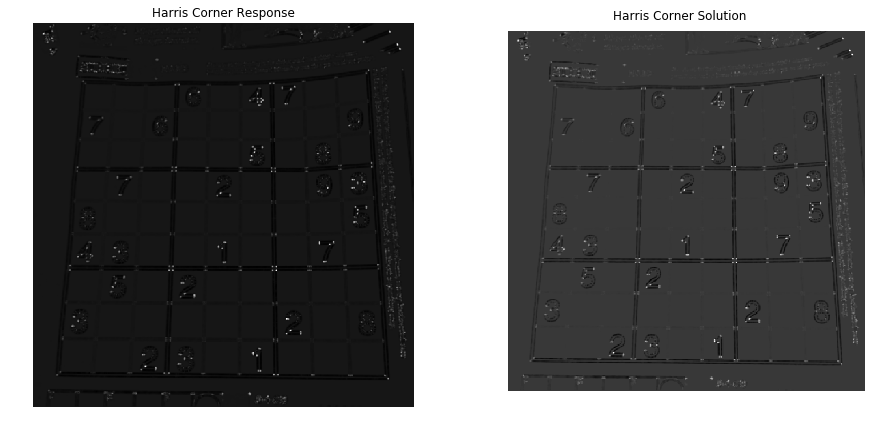

In [4]:
from panorama import harris_corners

img = imread('sudoku.png', as_grey=True)

# Compute Harris corner response
response = harris_corners(img)

# Display corner response
plt.subplot(1,2,1)
plt.imshow(response)
plt.axis('off')
plt.title('Harris Corner Response')

plt.subplot(1,2,2)
plt.imshow(imread('solution_harris.png', as_grey=True))
plt.axis('off')
plt.title('Harris Corner Solution')

plt.show()

Once you implement the Harris detector correctly, you will be able to see small bright blobs around the corners of the sudoku grids and letters in the output corner response image. The function `corner_peaks` from `skimage.feature` performs non-maximum suppression to take local maxima of the response map and localize keypoints.

**对响应输出进行非极大抑制。**

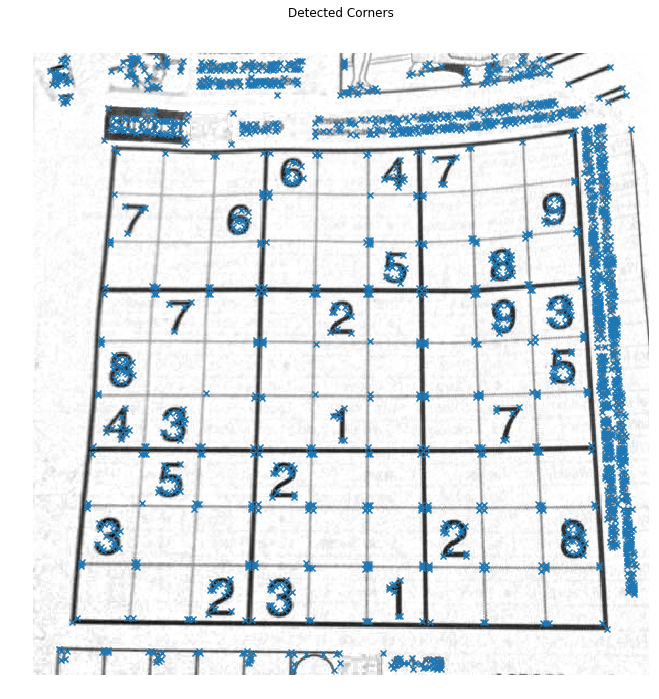

In [5]:
# Perform non-maximum suppression in response map
# and output corner coordiantes
corners = corner_peaks(response, threshold_rel=0.01)

# Display detected corners
plt.imshow(img)
plt.scatter(corners[:,1], corners[:,0], marker='x')
plt.axis('off')
plt.title('Detected Corners')
plt.show()

## Part 2 Describing and Matching Keypoints (20 points)

We are now able to localize keypoints in two images by running the Harris corner detector independently on them. Next question is, how do we determine which pair of keypoints come from corresponding locations in those two images? In order to *match* the detected keypoints, we must come up with a way to *describe* the keypoints based on their local appearance. Generally, each region around detected keypoint locations is converted into  a fixed-size vectors called *descriptors*.

### Part 2.1 Creating Descriptors (10 points)

In this section, you are going to implement a **`simple_descriptor`**; each keypoint is described by normalized intensity in a small patch around it.


为了进行两幅图像中的关键点的点与点之间的匹配，需要对关键点进行描述。

此时，提出描述符对关键点的局部特征进行描述。

一般来说，描述符就是将检测到的关键点的附近区域转换成固定大小的向量。

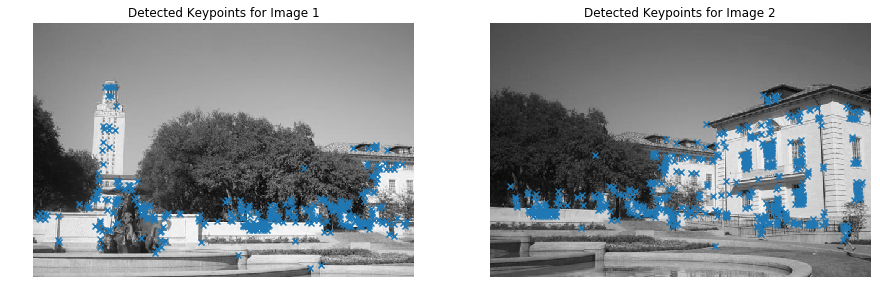

In [6]:
from panorama import harris_corners

img1 = imread('uttower1.jpg', as_grey=True)
img2 = imread('uttower2.jpg', as_grey=True)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()

### Part 2.2 Matching Descriptors (10 points)
Then, implement **`match_descriptors`** function to find good matches in two sets of descriptors. First, calculate Euclidean distance between all pairs of descriptors from image 1 and image 2. Then use this to determine if there is a good match: if the distance to the closest vector is significantly (by a factor which is given) smaller than the distance to the second-closest, we call it a match. The output of the function is an array where each row holds the indices of one pair of matching descriptors.

- 使用标准化的密度来作为描述子
- 使用欧几里得距离来对描述子进行匹配,当最短距离与第二短距离的比值小于阈值，则判定为匹配

> 这份教程有帮助：[查找最大或最小的 N 个元素](https://python3-cookbook.readthedocs.io/zh_CN/latest/c01/p04_find_largest_or_smallest_n_items.html)

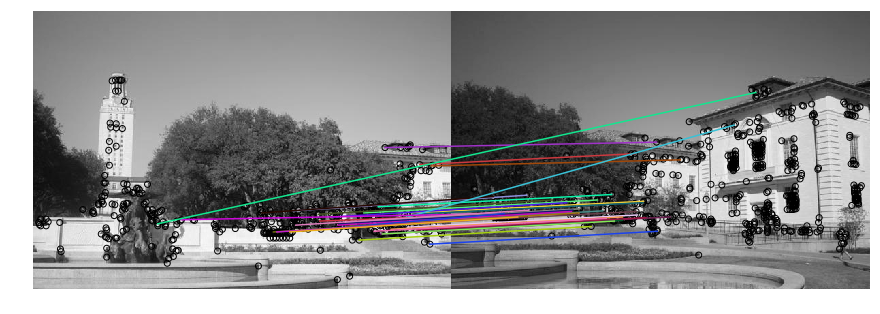

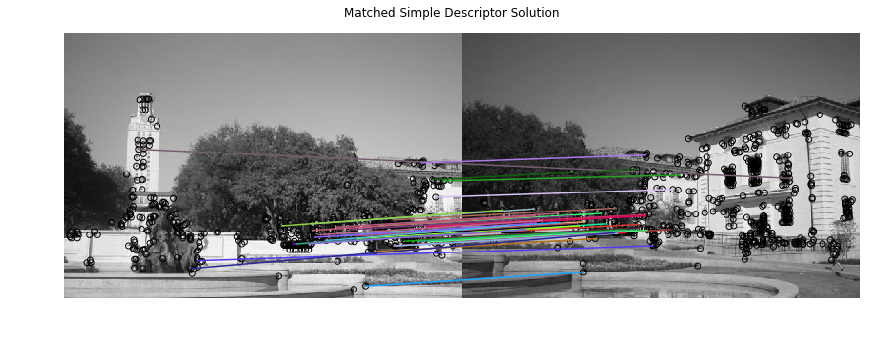

In [7]:
from panorama import simple_descriptor, match_descriptors, describe_keypoints
from utils import plot_matches

patch_size = 5

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()
plt.imshow(imread('solution_simple_descriptor.png'))
plt.axis('off')
plt.title('Matched Simple Descriptor Solution')
plt.show()

## Part 3 Transformation Estimation (20 points)

We now have a list of matched keypoints across the two images. We will use this to find a transformation matrix that maps points in the second image to the corresponding coordinates in the first image. In other words, if the point $p_1 = [y_1,x_1]$ in image 1 matches with $p_2=[y_2, x_2]$ in image 2, we need to find an affine transformation matrix $H$ such that

$$
\tilde{p_2}H = \tilde{p_1},
$$

where $\tilde{p_1}$ and $\tilde{p_2}$ are homogenous coordinates of $p_1$ and $p_2$.

Note that it may be impossible to find the transformation $H$ that maps every point in image 2 exactly to the corresponding point in image 1. However, we can estimate the transformation matrix with least squares. Given $N$ matched keypoint pairs, let $X_1$ and $X_2$ be $N \times 3$ matrices whose rows are homogenous coordinates of corresponding keypoints in image 1 and image 2 respectively. Then, we can estimate $H$ by solving the least squares problem,

$$
X_2 H = X_1
$$

Implement **`fit_affine_matrix`** in `panorama.py`

*-Hint: read the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) about np.linalg.lstsq*

第三步就是要计算图2到图1的仿射变换矩阵。

由于匹配点对众多，这里采用最小二乘法估计变换矩阵。

In [8]:
from panorama import fit_affine_matrix

# Sanity check for fit_affine_matrix

# Test inputs
a = np.array([[0.5, 0.1], [0.4, 0.2], [0.8, 0.2]])
b = np.array([[0.3, -0.2], [-0.4, -0.9], [0.1, 0.1]])

H = fit_affine_matrix(b, a)

# Target output
sol = np.array(
    [[1.25, 2.5, 0.0],
     [-5.75, -4.5, 0.0],
     [0.25, -1.0, 1.0]]
)

error = np.sum((H - sol) ** 2)

if error < 1e-20:
    print('Implementation correct!')
else:
    print('There is something wrong.')

Implementation correct!


After checking that your `fit_affine_matrix function` is running correctly, run the following code to apply it to images.
Images will be warped and image 2 will be mapped to image 1. Then, the two images are merged to get a panorama. Your panorama may not look good at this point, but we will later use other techniques to get a better result.

Output shape: [ 410 1166]
Offset: [   0.         -142.02564331]


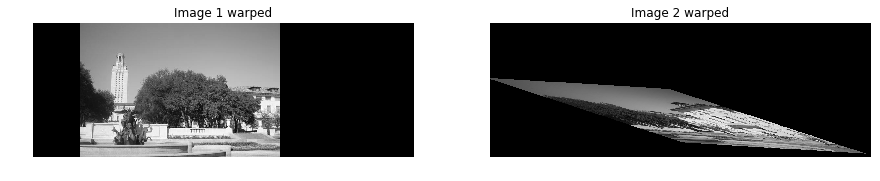

In [9]:
from utils import get_output_space, warp_image

# Extract matched keypoints
p1 = keypoints1[matches[:,0]]
p2 = keypoints2[matches[:,1]]

# Find affine transformation matrix H that maps p2 to p1
H = fit_affine_matrix(p1, p2)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)


# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

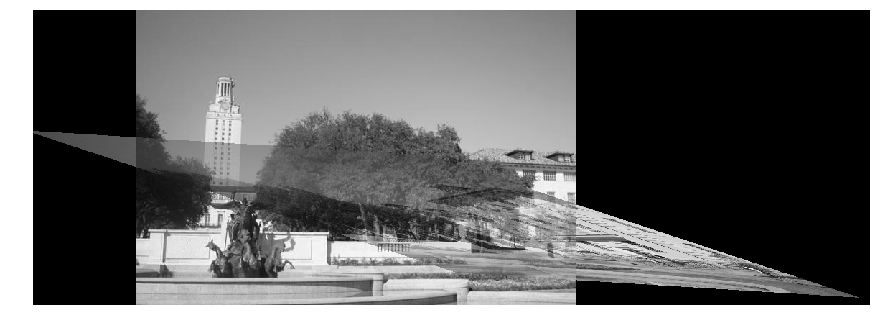

In [10]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

这啥玩意啊，脑袋巨大。

## Part 4 RANSAC (20 points)
Rather than directly feeding all our keypoint matches into ``fit_affine_matrix`` function, we can instead use RANSAC ("RANdom SAmple Consensus") to select only "inliers" to use to compute the transformation matrix.

The steps of RANSAC are:
    1. Select random set of matches
    2. Compute affine transformation matrix
    3. Find inliers using the given threshold
    4. Repeat and keep the largest set of inliers
    5. Re-compute least-squares estimate on all of the inliers

Implement **`ransac`** in `panorama.py`, run through the following code to get a panorama. You can see the difference from the result we get without RANSAC.

告别直接使用所有匹配对进行仿射变换矩阵估计的方式，

我们迎来了RANSAC随机抽样一致的方式来对inliers(非异常点即正常点)进行仿射变换的估计。

RANSAC的步骤为：
1. 随机选取一组匹配点
2. 计算仿射变换矩阵
3. 根据给定的阈值计算在正常范围内的匹配对的数目
4. 不断重复，保留最大正常匹配对的数目
5. 对保留的最大整整匹配对进行最小二乘法的估计，得到图2到图1的仿射变换矩阵。

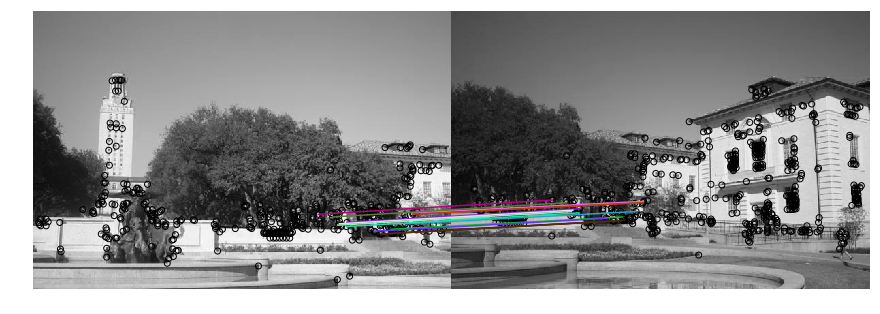

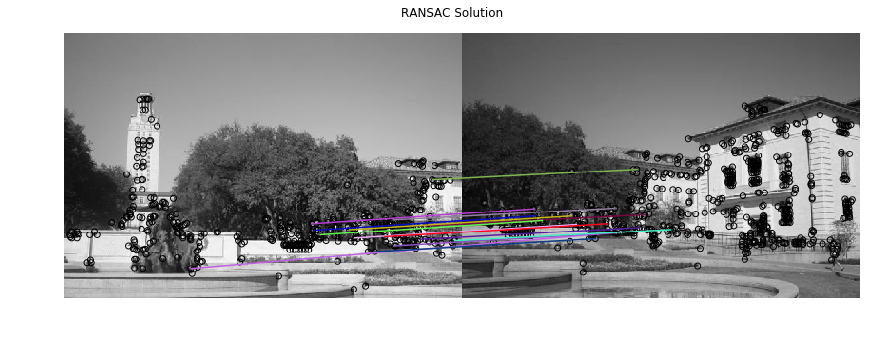

In [11]:
from panorama import ransac
H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)

# Visualize robust matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_ransac.png'))
plt.axis('off')
plt.title('RANSAC Solution')
plt.show()

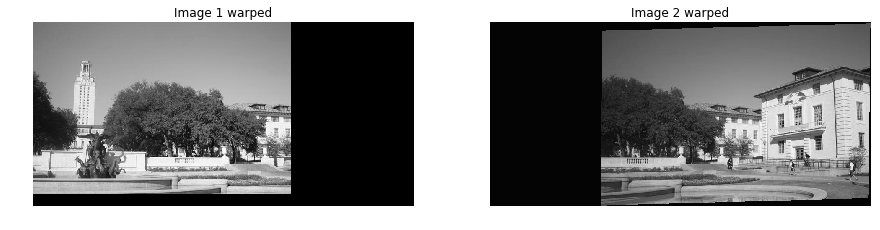

In [12]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

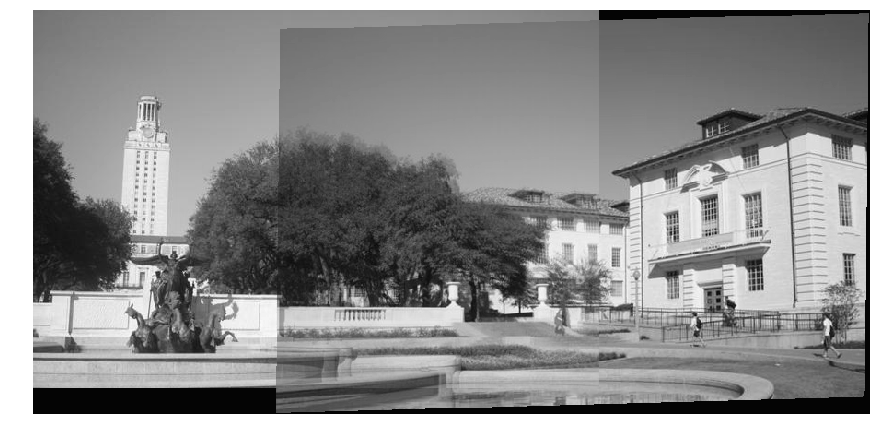

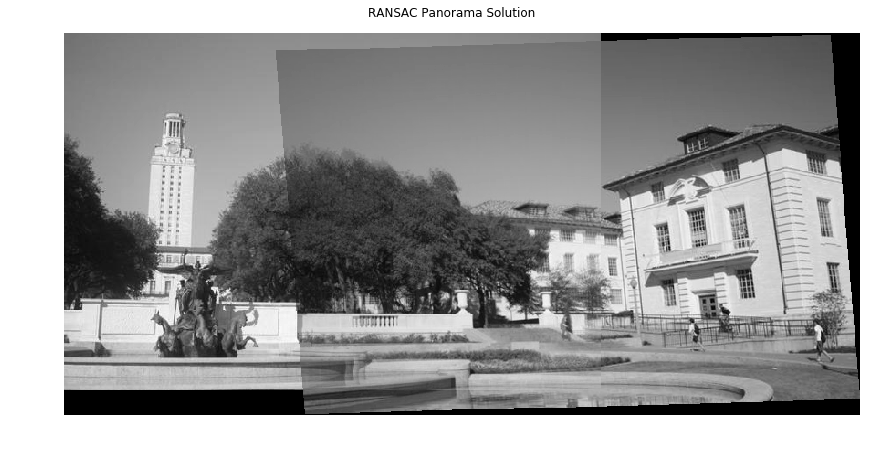

In [13]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_ransac_panorama.png'))
plt.axis('off')
plt.title('RANSAC Panorama Solution')
plt.show()

哇靠，真的能拼接出来了。

我偷看了一眼 [mikucy的作业](https://github.com/mikucy/CS131/blob/master/hw3_release/panorama.py)，感谢！

上学期没做出来是因为我在进行处理随机抽样一致的时候，只进行了一定数目迭代，并在迭代过程中保留了效果最好的变换矩阵，但这个矩阵仅仅是用随机的片段估计出来的；

实际上迭代过程中的参数估计只是为了得到最大数目的局内点inliers的，最终的参数估计即仿射变换矩阵还是要根据迭代后保留的inliers进行最小二乘法估计出来。

也就是说迭代过程中的最优H，并不是最终的H。

## Part 5 Histogram of Oriented Gradients (HOG) (20 points)
In the above code, you are using the `simple_descriptor`, and in this section, you are going to implement a simplified version of HOG descriptor. <br>
HOG stands for Histogram of	Oriented Gradients. In HOG descriptor, the distribution ( histograms ) of directions of gradients ( oriented gradients ) are used as features. Gradients ( x and y derivatives ) of an image are useful because the magnitude of gradients is large around edges and corners ( regions of abrupt intensity changes ) and we know that edges and corners pack in a lot more information about object shape than flat regions.<br>
The steps of HOG are: 
    1. compute the gradient image in x and y
        Use the sobel filter provided by skimage.filters
    2. compute gradient histograms
        Divide image into cells, and calculate histogram of gradient in each cell.
    3. normalize across block
        Normalize the histogram so that they 
    4. flattening block into a feature vector

Implement **`hog_descriptor`** in `panorama.py`, and run through the following code to get a panorama image.

HOG特征提取步骤（简化版本）：
1. 计算图像中x和y方向上的梯度
2. 计算梯度直方图
将图像分成多个单元，计算每个单元内的梯度分布，梯度分布n个方向中，统计单元内每个方向的梯度强度之和
3. 归一化图像块的直方图
4. 将块直方图转换成向量

>**博客推荐**
>
>关于HOG特征的算法流程，可以阅读此文
>
>[【特征检测】HOG特征算法](https://blog.csdn.net/hujingshuang/article/details/47337707)

In [14]:
from panorama import hog_descriptor

img1 = imread('uttower1.jpg', as_grey=True)
img2 = imread('uttower2.jpg', as_grey=True)

# Detect keypoints in both images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)


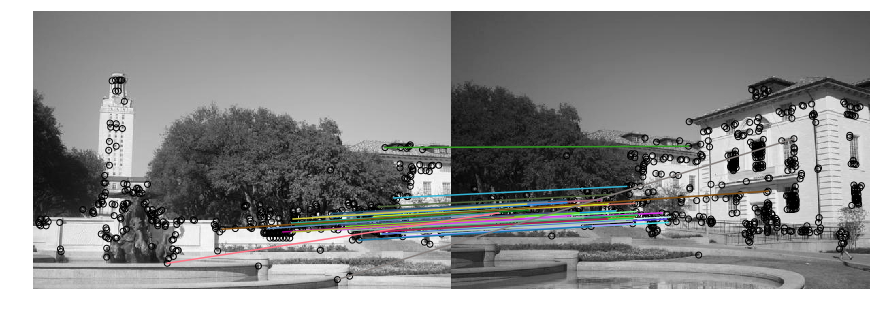

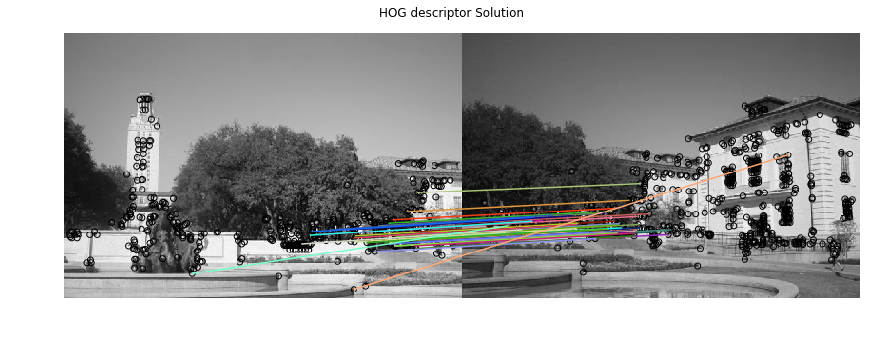

In [15]:
# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=hog_descriptor,
                           patch_size=16)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=hog_descriptor,
                           patch_size=16)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()
plt.imshow(imread('solution_hog.png'))
plt.axis('off')
plt.title('HOG descriptor Solution')
plt.show()

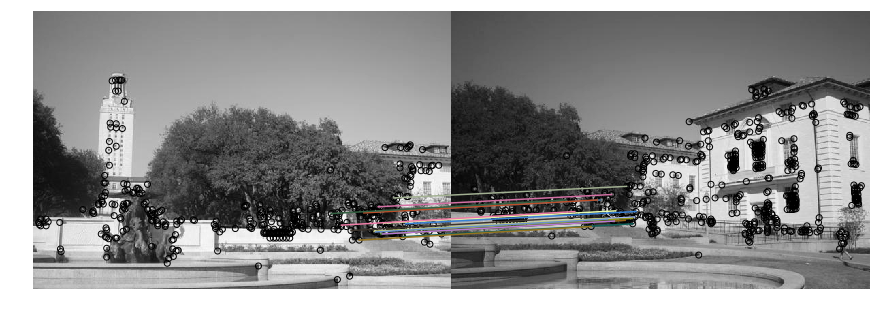

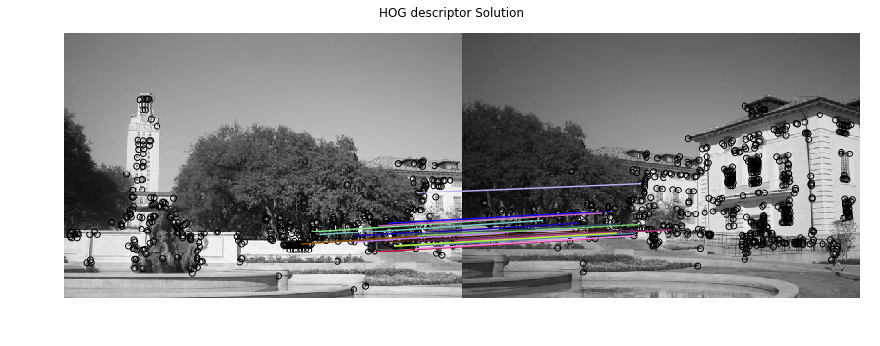

In [16]:
from panorama import ransac
H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_hog_ransac.png'))
plt.axis('off')
plt.title('HOG descriptor Solution')
plt.show()

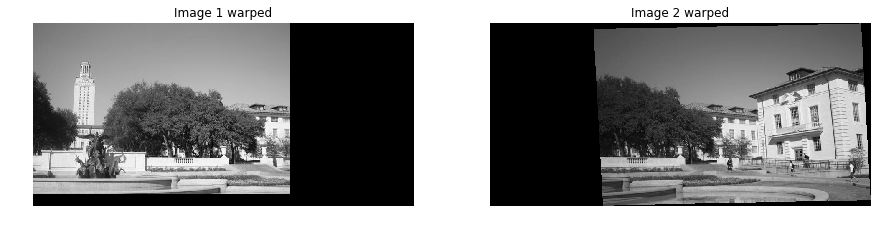

In [17]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

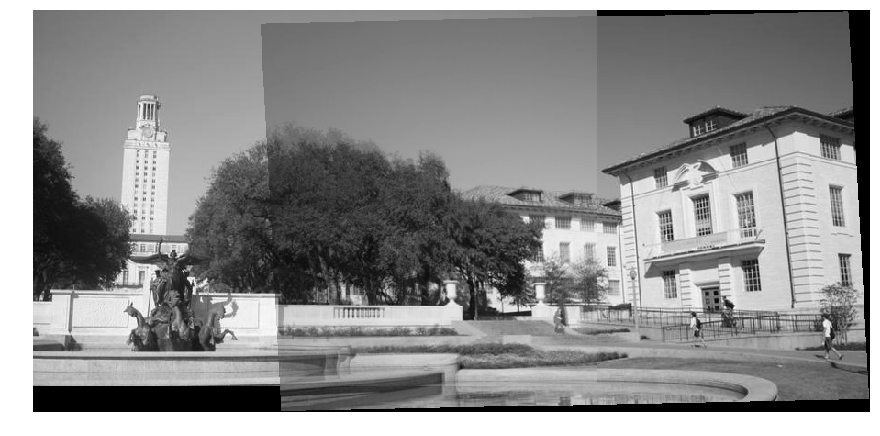

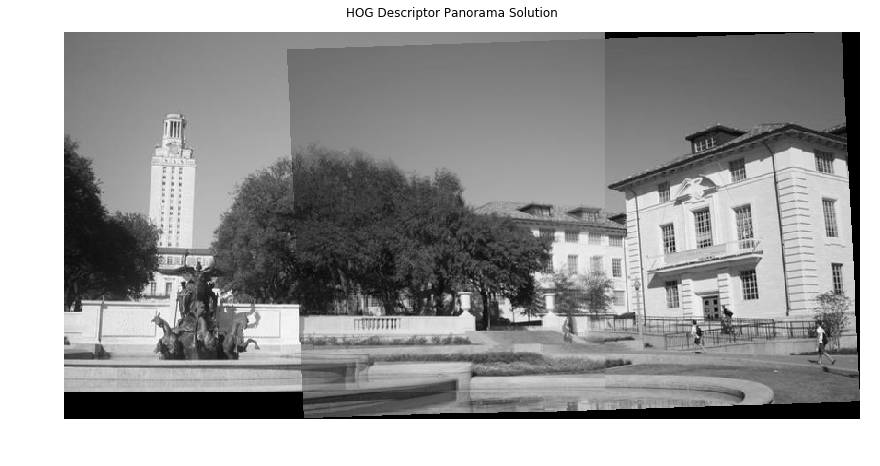

In [18]:
merged = img1_warped + img2_warped

# merge之后重叠部分亮度上来了，需要通过归一化回复原来亮度
# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_hog_panorama.png'))
plt.axis('off')
plt.title('HOG Descriptor Panorama Solution')
plt.show()

实现了**HOG特征描述符**之后，可以替代掉之前的**归一化密度**作为特征的匹配。，效果还不错。

## Extra Credit: Better Image Merging
You will notice the blurry region and unpleasant lines in the middle of the final panoramic image. In the cell below, come up with a better merging scheme to make the panorama look more natural. Be creative!

**怎么消除拼接处的两条拼接痕迹呢？**

>第一，翻博客  [OpenCV探索之路（二十四）图像拼接和图像融合技术](https://www.cnblogs.com/skyfsm/p/7411961.html?tdsourcetag=s_pctim_aiomsg)
>
>第二，看论文 [《Automatic Panoramic Image Stitching using Invariant Features》](http://matthewalunbrown.com/papers/ijcv2007.pdf)
>

**加权融合**

博客上的处理思路是加权融合，在重叠部分由前一幅图像慢慢过渡到第二幅图像，即将图像的重叠区域的像素值按一定的权值相加合成新的图像。

我的理解就是两块重叠的区域，从左向右每个像素由图1和图2融合，最开始图1的权重最大，图2的权重最小，向右融合过程中图1权重逐渐减小，图2权重逐渐增大。

融合的公式可以简单理解成：
$$
dst[i,j] = Img_1[i,j] * \alpha_{[i,j]}+ Img_2[i,j] * (1-\alpha_{[i,j]})
$$

而权重$\alpha$的则与像素点在重叠区域的位置相关，可以定义成：
$$
\alpha_{[row,col]} = (col - Left_{region}) / (Width_{region})  
$$


**增益补偿和多频带混合**
论文《Automatic Panoramic Image Stitching using Invariant Features》正是一篇不错的文章啊，我快速过了一遍。

论文针对拼接步骤，提出了三点：
1. 自动拼接校直 Automatic Panorama Straightening
2. 增益补偿 Gain Compensation
3. 多频带混合 Multi-Band Blending

校直是用BA做的相机参数的估计，用来解决拼接过程中的图像的旋转

增益补偿是用过使用最小二乘法计算每个拼接块的增益，用来均衡整幅图像中各个拼接块的亮度不均问题

多频带混合还没有看懂

实现的话目前没有动力实现了。加一个TODO，后面用空再做吧，而且BA实现这种东西，我的C++还半生不熟，Python下更是有心无力了。

TODO：实现《Automatic Panoramic Image Stitching using Invariant Features》

不过GitHub上倒是有个开源的拼接库[OpenPano](https://github.com/ppwwyyxx/OpenPano)，感兴趣可以看一下。

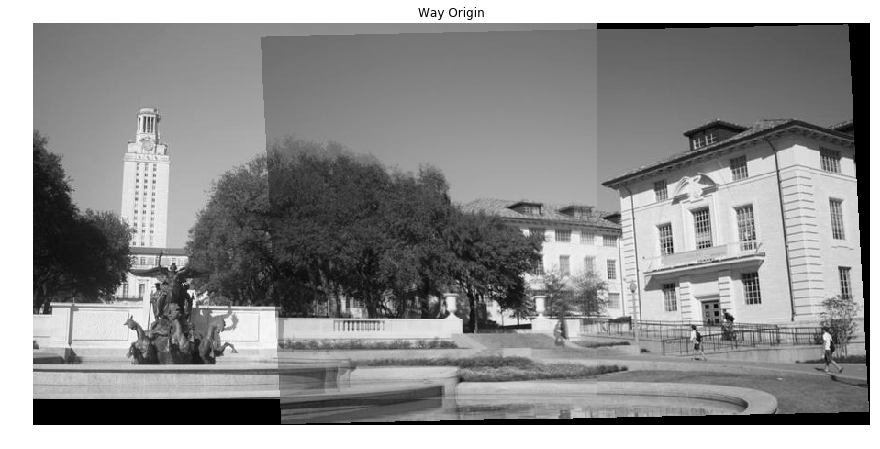

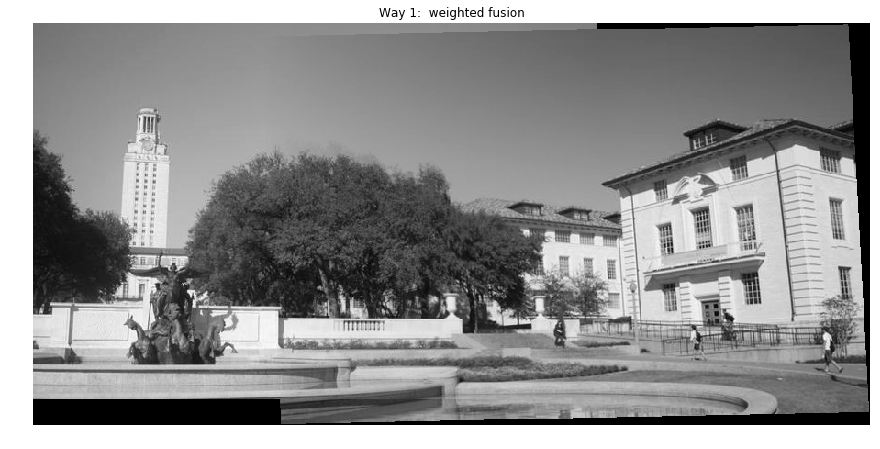

In [23]:
# Modify the code below

### YOUR CODE HERE

# #  拼接方法一：题目原有方法，两幅图叠加后在对重叠区域和非重叠区域做亮度调整。
merged = img1_warped + img2_warped
overlap = (img1_mask * 1.0 + img2_mask)
output = merged / np.maximum(overlap, 1)

plt.imshow(output)
plt.axis('off')
plt.title('Way Origin')
plt.show()

# 拼接方法二：加权融合
# 先把两幅图叠加在一起
merged = img1_warped + img2_warped
# overlap = (img1_mask * 1.0 + img2_mask)
# output = merged / np.maximum(overlap, 1)
# 1. 找到重叠区域在warped图像中的左边界和右边界，可以根据已知的mask图像进行判断
# 1.1 重叠区域左边界就是img2_mask中第一个不全为零的列
for col in range(img2_warped.shape[1]):
    if not np.all(img2_mask[:, col] == False):
        break
regionLeft = col
# 1.2 重叠区域右边界就是img1_mask中有值区域的右边，其实就是img1的宽所在的列
regionRight = img1.shape[1]
# 1.3 区域宽度
regionWidth = regionRight - regionLeft + 1

# 2. 遍历区域内像素点进行融合
for col in range(regionLeft, regionRight+1):
    for row in range(img2_warped.shape[0]):
        # 2.1 计算α
        alpha = (col - regionLeft) / (regionWidth)
        alpha = 1 - alpha
        # 2.2 处理区域内的重叠点
        if img1_mask[row,col] and img2_mask[row,col]:
            merged[row,col] = alpha * img1_warped[row,col] + (1 - alpha) * img2_warped[row,col]
        
output = merged

plt.imshow(output)
plt.axis('off')
plt.title('Way 1:  weighted fusion')
plt.show()
### END YOUR CODE

## Extra Credit: Stitching Multiple Images
Work in the cell below to complete the code to stitch an ordered chain of images.

Given a sequence of $m$ images ($I_1, I_2,...,I_m$), take every neighboring pair of images and compute the transformation matrix which converts points from the coordinate frame of $I_{i+1}$ to the frame of $I_{i}$. Then, select a reference image $I_{ref}$, which is in the middle of the chain. We want our final panorama image to be in the coordinate frame of $I_{ref}$. So, for each $I_i$ that is not the reference image, we need a transformation matrix that will convert points in frame $i$ to frame $ref$.

*-Hint:*
- If you are confused, you may want to review the Linear Algebra slides on how to combine the effects of multiple transformation matrices.
- The inverse of transformation matrix has the reverse effect. Please use [`numpy.linalg.inv`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) function whenever you want to compute matrix inverse.

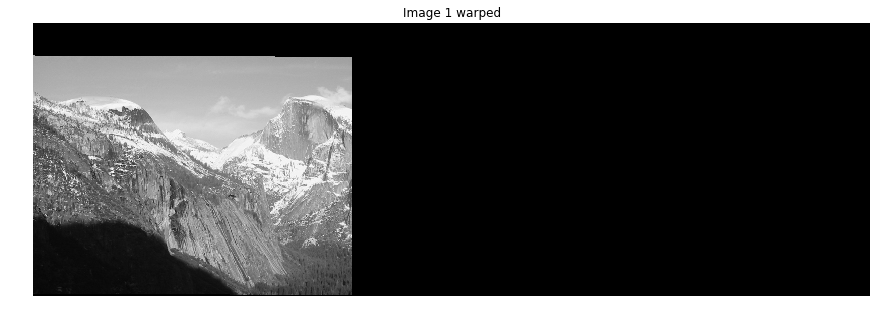

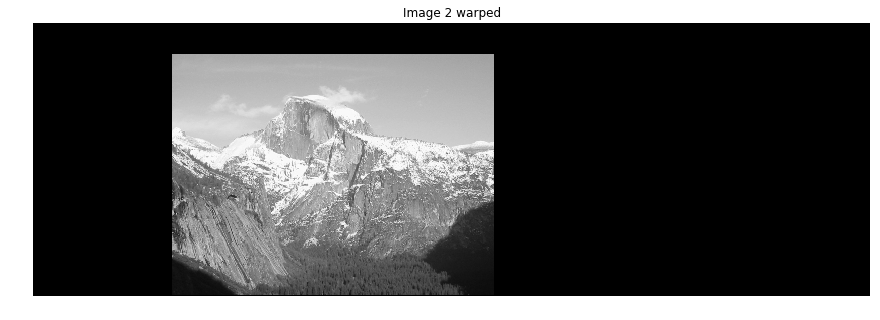

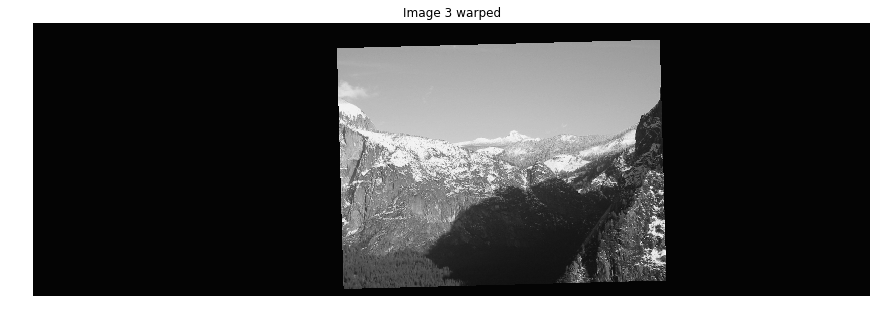

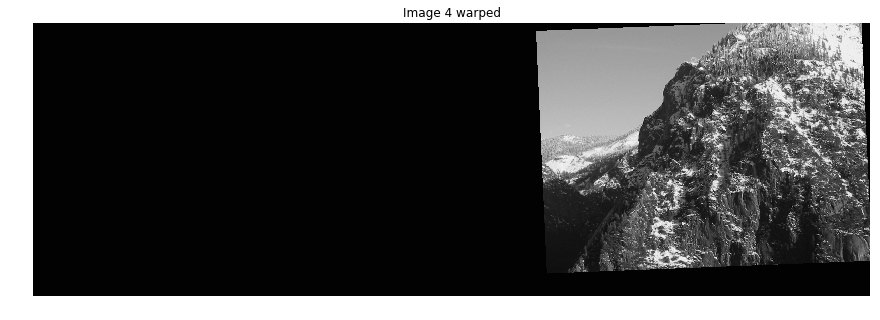

In [28]:
img1 = imread('yosemite1.jpg', as_grey=True)
img2 = imread('yosemite2.jpg', as_grey=True)
img3 = imread('yosemite3.jpg', as_grey=True)
img4 = imread('yosemite4.jpg', as_grey=True)

# Detect keypoints in each image
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints3 = corner_peaks(harris_corners(img3, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints4 = corner_peaks(harris_corners(img4, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Describe keypoints
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc3 = describe_keypoints(img3, keypoints3,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc4 = describe_keypoints(img4, keypoints4,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

# Match keypoints in neighboring images
matches12 = match_descriptors(desc1, desc2, 0.7)
matches23 = match_descriptors(desc2, desc3, 0.7)
matches34 = match_descriptors(desc3, desc4, 0.7)

### YOUR CODE HERE
# RANSAC 估计 仿射变换矩阵
H12, robust_matches12 = ransac(keypoints1, keypoints2, matches12, threshold=1)
H23, robust_matches23 = ransac(keypoints2, keypoints3, matches23, threshold=1)
H34, robust_matches34 = ransac(keypoints3, keypoints4, matches34, threshold=1)

# 生成outspace大背景
# 注意utils.py中的get_output_space用法，参数2:imgs与参数3：transforms要对应
# 注意选取referImg 参考图像，这里选择图2
output_shape, offset = get_output_space(img2, [img1, img3, img4], [np.linalg.inv(H12), H23, np.dot(H23,H34)])

# 将图像放入大背景中
# Warp images into output sapce
img1_warped = warp_image(img1, np.linalg.inv(H12), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, np.eye(3), output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

img3_warped = warp_image(img3, H23, output_shape, offset)
img3_mask = (img3_warped != -1) # Mask == 1 inside the image
img3_warped[~img3_mask] = 0     # Return background values to 0

img4_warped = warp_image(img4,  np.dot(H23,H34), output_shape, offset)
img4_mask = (img4_warped != -1) # Mask == 1 inside the image
img4_warped[~img4_mask] = 0     # Return background values to 0


plt.imshow(img1_warped)
plt.axis('off')
plt.title('Image 1 warped')
plt.show()

plt.imshow(img2_warped)
plt.axis('off')
plt.title('Image 2 warped')
plt.show()

plt.imshow(img3_warped)
plt.axis('off')
plt.title('Image 3 warped')
plt.show()

plt.imshow(img4_warped)
plt.axis('off')
plt.title('Image 4 warped')
plt.show()

### END YOUR CODE

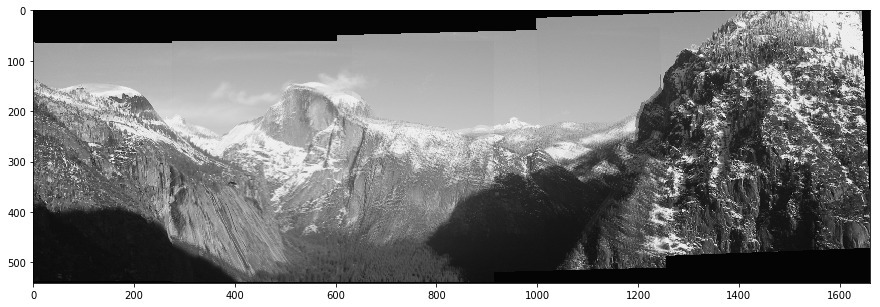

In [30]:
#  进行拼接，拼接方式一
merged = img1_warped + img2_warped + img3_warped + img4_warped

# Track the overlap by adding the masks together
overlap = (img2_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img1_mask + img3_mask + img4_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

plt.imshow(normalized)
plt.show()

多幅图的拼接就可以看出来简单方式的问题了：
1. 拼接痕迹的存在，可以使用加权平均，
2. 各个拼接块亮度不均匀，需要做增益补偿，
3. 存在未知的图像的旋转，可能是由于拍摄时相机发生了位姿的变动，需要做优化处理（校直），
4. 重叠部分的拼接并不能直接实现所有像素的对应叠加，可以看出来存在模糊的情况，可以使用多频带混合的方式去做处理。

这些在《Automatic Panoramic Image Stitching using Invariant Features》都提到了。感兴趣可以继续研究，我先做下一份作业了。